In [1]:
# Source for Images: https://www.kaggle.com/code/basu369victor/image-colorization-basic-implementation-with-cnn/input
# Source for Images: https://github.com/guilbera/colorizing
# Source for Code (Reference): https://anne-guilbert.medium.com/black-and-white-image-colorization-with-deep-learning-53855922cda6

# Import needed libraries
from keras.models import Sequential
from keras.layers import Conv2D, UpSampling2D
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave, imshow
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

h:\Anaconda-Installation\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
root_dir = "./datasets/training"

img_data_gen = ImageDataGenerator(rescale=(1.0 / 255))

training_images = img_data_gen.flow_from_directory(directory=root_dir, target_size=(224, 224), shuffle=False, batch_size=20, class_mode=None)
training_images, type(training_images), len(training_images)

Found 9294 images belonging to 1 classes.


(<keras.src.preprocessing.image.DirectoryIterator at 0x1ef579a30d0>,
 keras.src.preprocessing.image.DirectoryIterator,
 465)

In [3]:
X, y = [], []
for image in training_images[0]:
    try:
        image_LAB = rgb2lab(image)
        X.append(image_LAB[:, :, 0])
        y.append((image_LAB[:,:, 1:]) / 128)
    except:
        print("Error in conversion or calculation")
X = np.array(X)
y = np.array(y)
X = X.reshape(X.shape + (1,))
X.shape, y.shape

((20, 224, 224, 1), (20, 224, 224, 2))

In [4]:
# Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation="relu", padding="same", strides=2, input_shape=(224, 224, 1)))
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(128, (3, 3), activation="relu", padding="same", strides=2))
model.add(Conv2D(256, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(256, (3, 3), activation="relu", padding="same", strides=2))
model.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(256, (3, 3), activation="relu", padding="same"))

In [5]:
# Decoder
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(16, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(2, (3, 3), activation="tanh", padding="same"))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 256)       590080    
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 512)       1180160   
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 512)       2

In [6]:
model.fit(X, y, validation_split=0.1, epochs=1000, batch_size=10)

model.save("models/image_colorization_cnn.model")

Epoch 1/1000
2/2 [==============================] - 6s 2s/step - loss: 0.4434 - accuracy: 0.3794 - val_loss: 0.9038 - val_accuracy: 0.4179
Epoch 2/1000
2/2 [==============================] - 3s 2s/step - loss: 0.9242 - accuracy: 0.3210 - val_loss: 0.2901 - val_accuracy: 0.4215
Epoch 3/1000
2/2 [==============================] - 3s 2s/step - loss: 0.2180 - accuracy: 0.3242 - val_loss: 0.0082 - val_accuracy: 0.4144
Epoch 4/1000
2/2 [==============================] - 3s 2s/step - loss: 0.0079 - accuracy: 0.5080 - val_loss: 0.0063 - val_accuracy: 0.5761
Epoch 5/1000
2/2 [==============================] - 3s 2s/step - loss: 0.0079 - accuracy: 0.6244 - val_loss: 0.0064 - val_accuracy: 0.5657
Epoch 6/1000
2/2 [==============================] - 4s 2s/step - loss: 0.0071 - accuracy: 0.6616 - val_loss: 0.0078 - val_accuracy: 0.3745
Epoch 7/1000
2/2 [==============================] - 4s 2s/step - loss: 0.0090 - accuracy: 0.4386 - val_loss: 0.0057 - val_accuracy: 0.5865
Epoch 8/1000
2/2 [=========

INFO:tensorflow:Assets written to: models/image_colorization_cnn.model\assets


In [7]:
# Needed if you are loading in the model here from local file directory
model = tf.keras.models.load_model("models/image_colorization_cnn.model",
                                   custom_objects=None,
                                   compile=True)

In [8]:
test_img_color_list = []

test_img_color = load_img("datasets/testing/test_images/1QejlL 4.11.06 PM.jpg")
test_img_color_copy = test_img_color.copy()
test_img_color = img_to_array(test_img_color)
test_img_color = resize(test_img_color, (224, 224), anti_aliasing=True)
test_img_color_list.append(test_img_color)
test_img_color

array([[[ 38.510204,  38.510204,  38.510204],
        [ 44.117348,  44.117348,  44.117348],
        [ 53.47959 ,  53.47959 ,  53.47959 ],
        ...,
        [117.668365, 117.668365, 117.668365],
        [117.27041 , 117.27041 , 117.27041 ],
        [115.34694 , 115.34694 , 115.34694 ]],

       [[ 42.086735,  42.086735,  42.086735],
        [ 50.30612 ,  50.30612 ,  50.30612 ],
        [ 63.086735,  63.086735,  63.086735],
        ...,
        [118.64286 , 118.64286 , 118.64286 ],
        [118.30612 , 118.30612 , 118.30612 ],
        [118.015305, 118.015305, 118.015305]],

       [[ 45.622448,  45.622448,  45.622448],
        [ 55.4949  ,  55.4949  ,  55.4949  ],
        [ 70.581635,  70.581635,  70.581635],
        ...,
        [120.89796 , 120.89796 , 120.89796 ],
        [119.63265 , 119.63265 , 119.63265 ],
        [118.7602  , 118.7602  , 118.7602  ]],

       ...,

       [[ 63.780613,  63.780613,  63.780613],
        [ 64.78061 ,  64.78061 ,  64.78061 ],
        [ 65.41327 ,  

In [9]:
test_img_color_list = np.array(test_img_color_list, dtype=float)
test_img_color_list = rgb2lab((1.0 / 255) * test_img_color_list)[:,:,:,0]
test_img_color_list = test_img_color_list.reshape(test_img_color_list.shape + (1,))

test_img_color_list

array([[[[15.40394569],
         [18.0579049 ],
         [22.37872364],
         ...,
         [49.50508195],
         [49.34667711],
         [48.57968871]],

        [[17.10296034],
         [20.92842429],
         [26.68942016],
         ...,
         [49.89257162],
         [49.7587384 ],
         [49.64310131]],

        [[18.76140893],
         [23.29263798],
         [29.9777181 ],
         ...,
         [50.78709557],
         [50.28556156],
         [49.93919124]],

        ...,

        [[26.99645201],
         [27.43797604],
         [27.71673258],
         ...,
         [ 3.82781281],
         [ 3.84480993],
         [ 3.76026342]],

        [[27.38397427],
         [27.90082481],
         [27.97485574],
         ...,
         [ 3.75186885],
         [ 3.63549469],
         [ 3.63549469]],

        [[28.32440503],
         [28.06230883],
         [28.527987  ],
         ...,
         [ 3.75186885],
         [ 3.63549469],
         [ 3.63549469]]]])

In [10]:
predict_img = model.predict(test_img_color_list) 
predict_img *= 128
predict_img 

1/1 [==============================] - 0s 295ms/step


array([[[[ 0.891973  ,  3.117859  ],
         [ 0.891973  ,  3.117859  ],
         [-0.9579058 ,  1.1060205 ],
         ...,
         [-2.3517854 , -1.017877  ],
         [-0.92690307, -1.0526706 ],
         [-0.92690307, -1.0526706 ]],

        [[ 0.891973  ,  3.117859  ],
         [ 0.891973  ,  3.117859  ],
         [-0.9579058 ,  1.1060205 ],
         ...,
         [-2.3517854 , -1.017877  ],
         [-0.92690307, -1.0526706 ],
         [-0.92690307, -1.0526706 ]],

        [[ 1.1400285 ,  4.748638  ],
         [ 1.1400285 ,  4.748638  ],
         [-0.8629392 ,  4.8105464 ],
         ...,
         [-1.8278162 , -1.1431493 ],
         [-1.8025808 , -0.07477567],
         [-1.8025808 , -0.07477567]],

        ...,

        [[-0.725855  , 13.841949  ],
         [-0.725855  , 13.841949  ],
         [-2.9295363 , 16.376862  ],
         ...,
         [ 1.550985  , -0.6679363 ],
         [ 2.2752516 ,  1.9613857 ],
         [ 2.2752516 ,  1.9613857 ]],

        [[ 3.4153993 , 14.9753065 

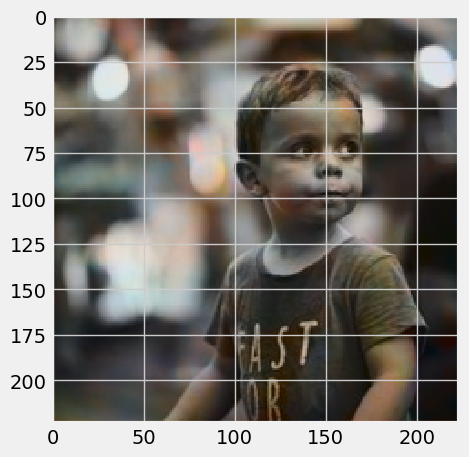

In [12]:
final_predict_img_result = np.zeros((224, 224, 3))
final_predict_img_result[:, :, 0] = test_img_color_list[0][:, :, 0]
final_predict_img_result[:, :, 1:] = predict_img[0]
imshow((lab2rgb(final_predict_img_result) * 255).astype(np.uint8))
imsave("result.png", (lab2rgb(final_predict_img_result) * 255).astype(np.uint8))